In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.style.use('seaborn-whitegrid')
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import scipy as sp

In [2]:
root_path = "Results/"

In [3]:
import glob
import pandas as pd
dataset = "MovieLens100K"
results_files_list = glob.glob(f"{root_path}/{dataset}/*.csv")

In [4]:
all_dfs = []

for result_file in results_files_list:
    result_df = pd.read_csv(result_file)
    all_dfs.append(result_df)

# concat all of the dataframes
results_df = pd.concat(all_dfs)

In [5]:
# print in latex format to put in the paper
# for eachline in results_df.itertuples(index=True):
  # print(f"{eachline.Model} & {eachline.Type} & {eachline.ndcg_ALL} & {eachline.CatCov_ALL} & {eachline.avg_JSH_all} & {eachline.avg_Hell_all} \\\\")

### Barplot Test vs. Train

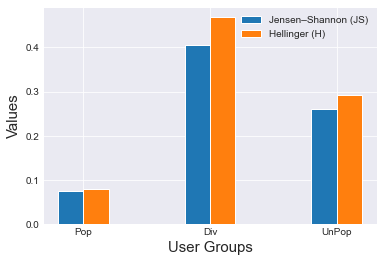

In [50]:
# set width of bar
barWidth = 0.20
# fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
JS = [0.07533822069457305, 0.4052769551083986, 0.2603085308559478]
Hell = [0.07875051012779152, 0.4679492188200486, 0.2919298883264158]
 
# Set position of bar on X axis
br1 = np.arange(len(JS))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, JS, width = barWidth, label ='Jensen–Shannon (JS)')
plt.bar(br2, Hell, width = barWidth, label ='Hellinger (H)')
 
# Adding Xticks
plt.xlabel('User Groups', fontsize = 15)
plt.ylabel('Values', fontsize = 15)
plt.xticks([r + 0.1 for r in range(len(JS))], ['Pop', 'Div', 'UnPop'])
 
plt.legend()
plt.savefig(f'plots/{dataset}/testvstrain_{dataset}.pdf', bbox_inches='tight')

### Heatmap for User Groups on CatCoverage

In [6]:
heatmap_df = pd.DataFrame(columns=['Model', 'Type', 'UserGroup', 'CatCov'])

for eachline in results_df.itertuples(index=True):
  if eachline.Type in ['CL', 'CCL']:
    heatmap_df = heatmap_df.append({'Model': eachline.Model,'Type': eachline.Type, 'UserGroup': 'Pop', 'CatCov': eachline.CatCov_POP}, ignore_index=True)
    heatmap_df = heatmap_df.append({'Model': eachline.Model,'Type': eachline.Type, 'UserGroup': 'Div', 'CatCov': eachline.CatCov_DIV}, ignore_index=True)
    heatmap_df = heatmap_df.append({'Model': eachline.Model,'Type': eachline.Type, 'UserGroup': 'UnPop', 'CatCov': eachline.CatCov_UNPOP}, ignore_index=True)

In [7]:
# group heatmap dataframe by model
group_heatmap_df = heatmap_df.groupby('UserGroup')

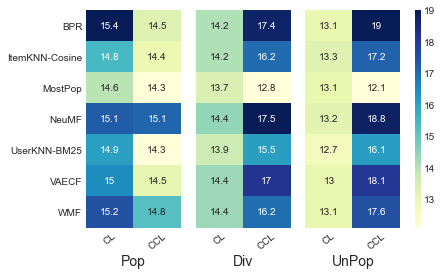

In [13]:
# generating heatmap for original and fair on UGF of Precision

df_Pop = group_heatmap_df.get_group('Pop').pivot("Model", "Type", "CatCov")
df_Div = group_heatmap_df.get_group('Div').pivot("Model", "Type", "CatCov")
df_UnPop = group_heatmap_df.get_group('UnPop').pivot("Model", "Type", "CatCov")

f, (ax0,ax1,ax2,axcb) = plt.subplots(1, 4, gridspec_kw={'width_ratios':[1, 1, 1, 0.06]}, figsize=(6, 4))

g0 = sns.heatmap(data=df_Pop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax0)
g0.set_ylabel('')
g0.set_xlabel('Pop', fontsize=14)

g1 = sns.heatmap(data=df_Div.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('Div', fontsize=14)
g1.set_yticks([])

g2 = sns.heatmap(data=df_UnPop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('UnPop', fontsize=14)
g2.set_yticks([])

# may be needed to rotate the ticklabels correctly:
for ax in [g0,g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=40)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.savefig(f'plots/{dataset}/heatmap_{dataset}.pdf', bbox_inches='tight')

### Line Chart

In [44]:
line_df = pd.DataFrame(columns=['Model', 'Type', 'NDCG', 'Precision', 'Recall', 'Novelty', 'Diversity', 'CatCov', 'Coverage'])

for eachline in results_df.itertuples(index=True):
  if eachline.Model not in ['ItemKNN-Cosine', 'UserKNN-BM25']:
    if eachline.Type in ['CL', 'CCL']:
      line_df = line_df.append({'Model': eachline.Model,'Type': eachline.Type, 'NDCG': eachline.ndcg_ALL, 'Precision': eachline.Pre_ALL,
      'Recall': eachline.Rec_ALL, 'Novelty': eachline.Nov_ALL, 'Diversity': eachline.Dive_ALL, 'CatCov': eachline.CatCov_ALL, 'Coverage': eachline.Cov_ALL},
      ignore_index=True)

In [45]:
line_df.head()

,Model,Type,NDCG,Precision,Recall,Novelty,Diversity,CatCov,Coverage
0,MostPop,CL,0.06641,0.06043,0.07129,1.97640,0.75354,13.72906,0.51
1,MostPop,CCL,0.06362,0.05731,0.06349,1.98351,0.72954,12.85714,0.56
2,NeuMF,CL,0.07313,0.06757,0.07661,2.25525,0.75794,14.39901,3.47
3,NeuMF,CCL,0.07291,0.06823,0.08091,2.27570,0.75945,17.46962,3.52
4,VAECF,CL,0.07035,0.06273,0.07414,2.03187,0.74841,14.32348,2.36


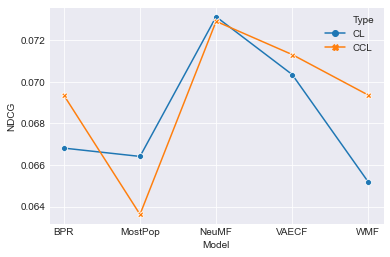

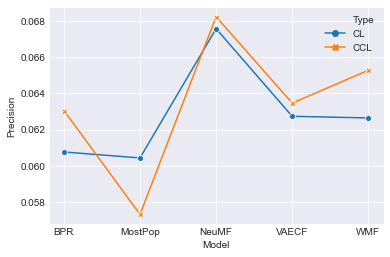

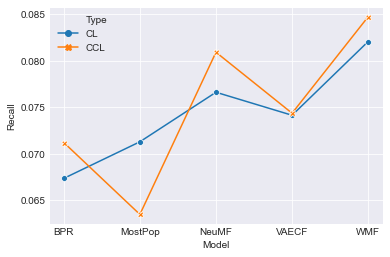

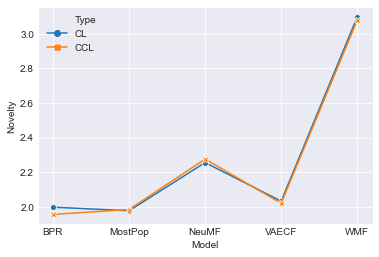

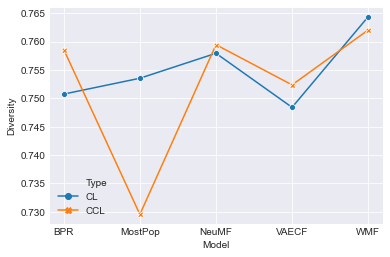

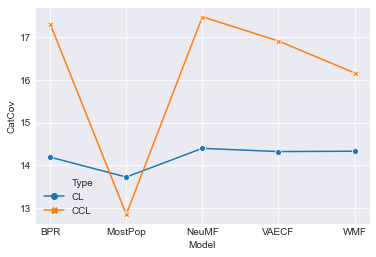

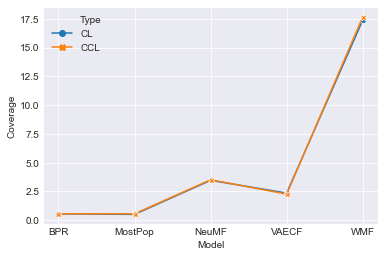

In [48]:
metrics = ['NDCG', 'Precision', 'Recall', 'Novelty', 'Diversity', 'CatCov', 'Coverage']
for metric in metrics:
    plt.figure()
    sns.lineplot(data=line_df, x="Model", y=metric, hue="Type", style="Type", markers=True, dashes=False)
    plt.savefig(f'plots/{dataset}/line_{metric}_{dataset}.pdf', bbox_inches='tight')